In [2]:
'''import packages'''
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

In [3]:
'''improt dataset and demand'''
small_data = pd.read_excel(r"C:\Users\allen\OneDrive\桌面\大規模最佳化\程式\Data.xlsx", sheet_name="small_data")
demand_small = pd.read_excel(r"C:\Users\allen\OneDrive\桌面\大規模最佳化\程式\Data.xlsx", sheet_name="Copy of Demand 3")

In [4]:
# 此處更改資料集 large & small
'''clean data'''
distance_matrix = small_data.drop(columns=['Unnamed: 0'])
distance_matrix = np.array(distance_matrix) # convert pandas to numpy
distance_matrix[distance_matrix==0]=np.inf # convert 0 to inf


'''clean demand'''
demand_small = demand_small.drop(columns=['Node'])
demand_small = np.array(demand_small)

In [83]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_cycles, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_cycles (int): Number of cycles
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_cycles = n_cycles
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        
        '''set truck and drones specs'''
        self.drone_payload = 100
        self.drone_distance = 50
        self.truck_payload = 2800
        self.truck_distance = 500

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        total_distance = []
        
        # 執行 n 次 cycles times
        for i in range(self.n_cycles):
            all_paths = self.gen_all_paths() # 產生每隻螞蟻走的路徑 
            self.spread_pheronome(all_paths, self.n_best, shortest_path = shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay
            total_distance.append(shortest_path[1])

        return all_time_shortest_path, total_distance, all_paths

    def gen_all_paths(self):
        '''產生每隻螞蟻的路徑'''
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0) # 產生每隻螞蟻走的路徑
            all_paths.append((path, self.gen_path_dist(path))) # 計算每隻螞蟻路徑的 total distance

        return all_paths
            
    def spread_pheronome(self, all_paths, n_best, shortest_path):
        '''走過的路徑增加 pheronmone'''
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        # 設定只有前 n 隻表現最佳的螞蟻需要紀錄
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]
                
    def gen_path(self, start):
        '''一隻螞蟻完成一趟 cycle 的 path'''
        path = []
        visited = set()
        drone_distance = self.drone_distance
        drone_payload = self.drone_payload
        visited.add(start)
        prev = start
        
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            
            # 判斷無人機是否要使用
            if demand_small[move] <= drone_payload:
                if self.distances[(prev, move)]*2 <= drone_distance:
                    drone_distance -= self.distances[(prev, move)]*2
                    visited.add(move)
                    continue
            
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started

        return path
    

    def gen_path_dist(self, path):
        '''計算每隻螞蟻路徑的 total distance'''
        total_dist = 0
        
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist



    def pick_move(self, pheromone, dist, visited):
        '''計算 probability 選擇 step '''
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        rho = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)
        norm_rho = rho / rho.sum()
        move = np_choice(self.all_inds, 1, p=norm_rho)[0]

        return move

In [82]:
ant_colony = AntColony(distance_matrix, n_ants = 5, n_best = 1, n_cycles = 800, decay = 0.95, alpha=0.5, beta=1)
shortest_path, total_distance, all_paths = ant_colony.run()
print ("shorted_path: {}".format(shortest_path))

[(0, 8), (8, 10), (10, 11), (11, 4), (4, 5), (5, 2), (2, 7), (7, 12), (12, 9), (9, 1), (1, 0)]
[(0, 10), (10, 1), (1, 12), (12, 8), (8, 6), (6, 9), (9, 4), (4, 5), (5, 3), (3, 2), (2, 11), (11, 0)]
[(0, 4), (4, 6), (6, 11), (11, 10), (10, 7), (7, 3), (3, 5), (5, 8), (8, 9), (9, 12), (12, 2), (2, 0)]
[(0, 8), (8, 10), (10, 6), (6, 1), (1, 2), (2, 11), (11, 5), (5, 9), (9, 3), (3, 4), (4, 12), (12, 0)]
[(0, 10), (10, 8), (8, 2), (2, 11), (11, 7), (7, 3), (3, 4), (4, 5), (5, 12), (12, 1), (1, 0)]
([(0, 8), (8, 10), (10, 11), (11, 4), (4, 5), (5, 2), (2, 7), (7, 12), (12, 9), (9, 1), (1, 0)], 289.3)
[(0, 3), (3, 11), (11, 6), (6, 10), (10, 8), (8, 7), (7, 1), (1, 2), (2, 4), (4, 5), (5, 12), (12, 0)]
[(0, 9), (9, 8), (8, 10), (10, 5), (5, 12), (12, 11), (11, 7), (7, 3), (3, 2), (2, 4), (4, 0)]
[(0, 6), (6, 2), (2, 3), (3, 5), (5, 4), (4, 8), (8, 10), (10, 11), (11, 12), (12, 7), (7, 0)]
[(0, 10), (10, 4), (4, 5), (5, 2), (2, 7), (7, 8), (8, 12), (12, 3), (3, 11), (11, 6), (6, 0)]
[(0, 5), 

Text(0.5, 1.0, 'Small Dataset')

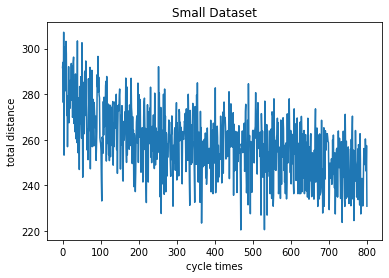

In [80]:
plt.plot(total_distance)
plt.xlabel("cycle times")
plt.ylabel("total distance")
plt.title("Small Dataset")
#plt.text(x=500, y=300, s = "alpha=0.5 ; beta=2")
